# Data Preparation

## 1. Import packages and retrieve data

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from datetime import datetime
import pandas as pd
import numpy as np
import json
import string, re
import pandas_profiling
import pickle

from local_modules.Pickling import pickle_item
import local_modules.slack as slack
import local_modules.DataPreparation as dp

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
data_iteration = 5
model_iteration = 3

In [6]:
data_file_path = 'data/20191108-' + str(data_iteration) + '_'
model_file_path = 'models/20191108-' + str(model_iteration) + '_'

In [2]:
%load_ext ipycache

c:\users\kingb\projects\poetry\fake_news_data_cup\.venv\lib\site-packages\IPython\config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
c:\users\kingb\projects\poetry\fake_news_data_cup\.venv\src\ipycache\ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [3]:
%%cache article_df_enriched.pkl article_df_enriched
%store -r article_df_enriched

[Skipped the cell's code and loaded variables article_df_enriched from file '/home/bking/Projects/pipenvs/Fake_News_Data_Cup/article_df_enriched.pkl'.]


## 2. Download NLTK corpora for stemming, tokenization, lemmatization
For more information: https://www.nltk.org/book/ch02.html

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

## 2. Get word count of articles

### 2.1 Tokenize, Stem, and Lemmatize 

In [4]:
article_df_enriched.head()

,id,text,word_count,token_count,sentence_count,brevity_score,filtered_text,nltk_pos_neg_neu_compound,nltk_pos,nltk_neg,nltk_neu,nltk_comp
0,106081,Trump Supporter “Kicked Pregnant Muslim Woman ...,225,330,14,0.681818,"[Trump, Supporter, “, Kicked, Pregnant, Muslim...","[0.027, 0.254, 0.719, -0.9973]",0.027,0.254,0.719,-0.9973
1,129341,UW Facts and Figures – University of Wisconsin...,50,69,2,0.724638,"[UW, Facts, Figures, –, University, Wisconsin–...","[0.0, 0.0, 1.0, 0.0]",0.000,0.000,1.000,0.0000
2,100963,Gun Control Advocates Target Peaceful Switzerl...,1055,1549,53,0.681085,"[Gun, Control, Advocates, Target, Peaceful, Sw...","[0.092, 0.101, 0.807, -0.8059]",0.092,0.101,0.807,-0.8059
3,12200,U.S. and Republic of Korea Conclude New Specia...,202,284,8,0.711268,"[U.S., Republic, Korea, Conclude, New, Special...","[0.221, 0.01, 0.769, 0.9952]",0.221,0.010,0.769,0.9952
4,128496,Kremlin's persistent claim of “expected chemic...,437,679,18,0.643594,"[Kremlin, 's, persistent, claim, “, expected, ...","[0.043, 0.13, 0.827, -0.9954]",0.043,0.130,0.827,-0.9954


In [5]:
ns = dp.remove_stopwords(article_df.iloc(0)[0]['text'])

In [ ]:
# Run functions and append to dataframe for word count, token count, and brevity score
dp.create_append_feature(article_df, 'text', 'claim_word_count', dp.get_word_count)
dp.create_append_feature(article_df, 'text', 'claim_token_count', dp.get_token_count)
dp.create_append_feature(article_df, 'text', 'claim_brevity_score', dp.get_brevity_score)
dp.create_append_feature(article_df, 'text', 'claim_filtered_text', dp.remove_stopwords)
dp.create_append_feature(article_df, 'text', 'claim_filtered_text', dp.get_sentiment_nltk_vader)

## 3. Generating sentiment data

### 3.1 Using NLTK vader
http://www.nltk.org/howto/sentiment.html


    neg: Negative
    neu: Neutral
    pos: Positive
    compound: Compound (i.e. aggregated score)


In [ ]:
dp.create_append_feature(article_df, 'claim_sentiment_nltk', dp.get_sentiment_nltk_vader, 'text')

In [ ]:
articles = article_df['filtered_text'].tolist()

In [11]:
article_df_enriched.head()

,id,text,word_count,token_count,sentence_count,brevity_score,filtered_text,nltk_pos_neg_neu_compound,nltk_pos,nltk_neg,nltk_neu,nltk_comp
0,106081,Trump Supporter “Kicked Pregnant Muslim Woman ...,225,330,14,0.681818,"[Trump, Supporter, “, Kicked, Pregnant, Muslim...","[0.027, 0.254, 0.719, -0.9973]",0.027,0.254,0.719,-0.9973
1,129341,UW Facts and Figures – University of Wisconsin...,50,69,2,0.724638,"[UW, Facts, Figures, –, University, Wisconsin–...","[0.0, 0.0, 1.0, 0.0]",0.000,0.000,1.000,0.0000
2,100963,Gun Control Advocates Target Peaceful Switzerl...,1055,1549,53,0.681085,"[Gun, Control, Advocates, Target, Peaceful, Sw...","[0.092, 0.101, 0.807, -0.8059]",0.092,0.101,0.807,-0.8059
3,12200,U.S. and Republic of Korea Conclude New Specia...,202,284,8,0.711268,"[U.S., Republic, Korea, Conclude, New, Special...","[0.221, 0.01, 0.769, 0.9952]",0.221,0.010,0.769,0.9952
4,128496,Kremlin's persistent claim of “expected chemic...,437,679,18,0.643594,"[Kremlin, 's, persistent, claim, “, expected, ...","[0.043, 0.13, 0.827, -0.9954]",0.043,0.130,0.827,-0.9954


In [ ]:
enriched_article_profile = article_df_enriched.profile_report(style={'full_width':True})
enriched_article_profile.to_file(output_file="data_profiles/enriched_article_data_profile.html")

In [ ]:
# Store article_df_enriched for loading in Model Development
article_df_enriched = article_df
%store article_df_enriched 

## 4. Training data preparation

Here we will summarize the article data for each claim, building the training data for model development. 
Summary statistics include mean, variance.

In [5]:
with open("data/train.json") as f:
    train_data = json.load(f)

train_df = pd.DataFrame.from_records(train_data)

In [8]:
train_df.head()

,claim,claimant,date,label,related_articles,id,num_related_articles,claim_nltk_sentiment
0,A line from George Orwell's novel 1984 predict...,anon,2017-07-17,0,"[122094, 122580, 130685, 134765]",0,4,"[0.173, 0.0, 0.827, 0.3182]"
1,Maine legislature candidate Leslie Gibson insu...,anon,2018-03-17,2,"[106868, 127320, 128060]",1,3,"[0.133, 0.176, 0.691, -0.2023]"
2,A 17-year-old girl named Alyssa Carson is bein...,anon,2018-07-18,1,"[132130, 132132, 149722]",4,3,"[0.0, 0.0, 1.0, 0.0]"
3,In 1988 author Roald Dahl penned an open lette...,anon,2019-02-04,2,"[123254, 123418, 127464]",5,3,"[0.0, 0.0, 1.0, 0.0]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6,6,"[0.0, 0.344, 0.656, -0.9001]"


In [7]:
# Add number of related articles to training data
train_df['num_related_articles'] = train_df['related_articles'].apply(lambda x: len(x))

In [ ]:
%%cache data/train_df.pkl train_df
%store -r train_df

In [ ]:
# Profile training data
profile_train_df = train_df.profile_report(style={'full_width':True})
profile_train_df.to_file(output_file="data_profiles/training_data_profile.html")

## 5. Fill out empty data for claimants

In [8]:
train_df['claimant'].replace('', 'anon', inplace=True)

## 6. Create claim sentiment data

In [9]:
dp.create_append_feature(train_df, 'claim', 'claim_nltk_sentiment', dp.get_sentiment_nltk_vader)

,claim,claimant,date,label,related_articles,id,num_related_articles,claim_nltk_sentiment
0,A line from George Orwell's novel 1984 predict...,anon,2017-07-17,0,"[122094, 122580, 130685, 134765]",0,4,"[0.173, 0.0, 0.827, 0.3182]"
1,Maine legislature candidate Leslie Gibson insu...,anon,2018-03-17,2,"[106868, 127320, 128060]",1,3,"[0.133, 0.176, 0.691, -0.2023]"
2,A 17-year-old girl named Alyssa Carson is bein...,anon,2018-07-18,1,"[132130, 132132, 149722]",4,3,"[0.0, 0.0, 1.0, 0.0]"
3,In 1988 author Roald Dahl penned an open lette...,anon,2019-02-04,2,"[123254, 123418, 127464]",5,3,"[0.0, 0.0, 1.0, 0.0]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6,6,"[0.0, 0.344, 0.656, -0.9001]"
...,...,...,...,...,...,...,...,...
15550,"The omnibus spending bill has ""9,427 pork barr...",John McCain,2009-02-25,2,"[82947, 93503]",17137,2,"[0.0, 0.0, 1.0, 0.0]"
15551,Representative Maxine Waters said Muslims were...,anon,2017-06-06,0,"[103780, 104726, 126025]",17138,3,"[0.0, 0.258, 0.742, -0.765]"
15552,"""We were not, I repeat, were not told that wat...",Nancy Pelosi,2009-04-23,0,"[11331, 68915, 2186, 2185, 88418, 81950]",17139,6,"[0.0, 0.0, 1.0, 0.0]"
15553,"As of August 2017, members of the public could...",anon,2018-05-14,2,"[121353, 152864, 154411]",17140,3,"[0.134, 0.075, 0.791, 0.3612]"


In [7]:
train_df = pickle.load(open('data/train_df.pkl', 'rb'))['train_df']

In [5]:
# train_df['num_related_articles']= train_df['related_articles'].apply(lambda x: len(x))
train_df['claim_pos'] = train_df['claim_nltk_sentiment'].apply(lambda x: x[0])
train_df['claim_neg'] = train_df['claim_nltk_sentiment'].apply(lambda x: x[1])
train_df['claim_neu'] = train_df['claim_nltk_sentiment'].apply(lambda x: x[2])
train_df['claim_comp'] = train_df['claim_nltk_sentiment'].apply(lambda x: x[3])

In [8]:
train_df.head()

,claim,claimant,date,label,related_articles,id,num_related_articles,claim_nltk_sentiment
0,A line from George Orwell's novel 1984 predict...,anon,2017-07-17,0,"[122094, 122580, 130685, 134765]",0,4,"[0.173, 0.0, 0.827, 0.3182]"
1,Maine legislature candidate Leslie Gibson insu...,anon,2018-03-17,2,"[106868, 127320, 128060]",1,3,"[0.133, 0.176, 0.691, -0.2023]"
2,A 17-year-old girl named Alyssa Carson is bein...,anon,2018-07-18,1,"[132130, 132132, 149722]",4,3,"[0.0, 0.0, 1.0, 0.0]"
3,In 1988 author Roald Dahl penned an open lette...,anon,2019-02-04,2,"[123254, 123418, 127464]",5,3,"[0.0, 0.0, 1.0, 0.0]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6,6,"[0.0, 0.344, 0.656, -0.9001]"


## 6. Split data into labels and features

In [9]:
# Labels are the values we want to predict
labels = train_df['label']
features = train_df \
    .drop('claim_nltk_sentiment', axis = 1) \
    .drop('claim', axis = 1) \
    .drop('label', axis = 1) \
    .drop('related_articles', axis = 1) \
    .drop('id', axis = 1) \

In [10]:
features.head()

,claimant,date,num_related_articles
0,anon,2017-07-17,4
1,anon,2018-03-17,3
2,anon,2018-07-18,3
3,anon,2019-02-04,3
4,Hillary Clinton,2016-03-22,6


In [18]:
# features['labels'] = labels

In [7]:
export_csv = features.to_csv(r'data/export_train_dataframe.csv', sep=',', header=True, index=False)

## 6. Standardization of data

How to encode claimant? High dimensionality

In [14]:
# Categorical boolean mask
categorical_feature_mask = features.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = features.columns[categorical_feature_mask].tolist()

In [15]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder# instantiate labelencoder object
le = LabelEncoder()

In [16]:
# apply le on categorical feature columns
features_categorical = features[categorical_cols].apply(lambda col: le.fit_transform(col))
features_categorical.head(10)

,claimant
0,3081
1,3081
2,3081
3,3081
4,1121
5,1650
6,1327
7,3081
8,2385
9,2001


In [30]:
le.inverse_transform([6047])

ValueError: y contains previously unseen labels: [6047]

In [28]:
for i, item in enumerate(features_categorical):
    print (item)
    
print(features_categorical.iloc(0)[0].values)

claimant
[3081]


In [31]:
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder# instantiate OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True ) 
# categorical_features = boolean mask for categorical columns
# sparse = False output an array not sparse matrix

In [9]:
# Alternative one hot encoding - using pandas.get_dummies
features_ohe_pandas = pd.get_dummies(features, prefix=['claimant'])

In [10]:
features_ohe_pandas.head()

,num_related_articles,claim_pos,claim_neg,claim_neu,claim_comp,"claimant_""A Woman’s Right to Know Information Material”","claimant_""suburban mom"" for Scott Taylor",claimant_@LagBeachAntifa9,claimant_@Sowellnomics,claimant_@WhiteHouse,...,claimant_religionmind.com,claimant_states-news.com,claimant_teaparty.org,claimant_therightwingportal.com,claimant_tmzbreaking,claimant_truthcommand.com,claimant_usaviralnews.info,claimant_whitehouse.gov,claimant_worldnewsdailyreport.com,claimant_Мikhail Aleksandrov
0,4,0.173,0.000,0.827,0.3182,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0.133,0.176,0.691,-0.2023,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0.000,0.000,1.000,0.0000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0.000,0.000,1.000,0.0000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0.000,0.344,0.656,-0.9001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
export_csv = features_ohe_pandas.to_csv(r'data/export_train_dataframe.csv', sep='\t', header=True, index=False)

In [61]:
from scipy.sparse import csr_matrix
S = csr_matrix(features_ohe)
print(S.shape)

(15555, 6047)


In [52]:
import scipy.sparse as ssp

In [67]:
# The above manipulations one-hot encode claimant. Use the below if you do not want a sparse vector
features_no_claimant = features.drop('claimant', axis = 1)

In [68]:
stacked=ssp.hstack( [S,features_no_claimant] ).todense()

In [69]:
stacked.shape

(15555, 6052)

In [91]:
labels_array = np.array(labels).reshape(15555,1)

In [93]:
np.append(stacked, labels_array, axis=1)

matrix([[ 0.    ,  0.    ,  0.    , ...,  0.827 ,  0.3182,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.691 , -0.2023,  2.    ],
        [ 0.    ,  0.    ,  0.    , ...,  1.    ,  0.    ,  1.    ],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  1.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.791 ,  0.3612,  2.    ],
        [ 0.    ,  0.    ,  0.    , ...,  1.    ,  0.    ,  1.    ]])

In [94]:
np.savetxt("data/dataset.csv", stacked, delimiter=",")

In [11]:
# Alternative one hot encoding - using pandas.get_dummies
features_ohe_pandas = pd.get_dummies(features, prefix=['claimant'])
from sklearn import preprocessing# Get column names first
names = features_ohe_pandas.columns# Create the Scaler object
scaler = preprocessing.StandardScaler()# Fit your data on the scaler object
scaled_features = scaler.fit_transform(features_ohe_pandas)
scaled_features = pd.DataFrame(scaled_features, columns=names)

# scaled_labels = scaler.fit_transform(labels.reshape(-1, 1))

In [12]:
scaled_features

,num_related_articles,claim_pos,claim_neg,claim_neu,claim_comp,"claimant_""A Woman’s Right to Know Information Material”","claimant_""suburban mom"" for Scott Taylor",claimant_@LagBeachAntifa9,claimant_@Sowellnomics,claimant_@WhiteHouse,...,claimant_religionmind.com,claimant_states-news.com,claimant_teaparty.org,claimant_therightwingportal.com,claimant_tmzbreaking,claimant_truthcommand.com,claimant_usaviralnews.info,claimant_whitehouse.gov,claimant_worldnewsdailyreport.com,claimant_Мikhail Aleksandrov
0,-0.257627,1.215599,-0.760486,-0.166028,0.878091,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018,...,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018
1,-0.516837,0.770264,0.776614,-1.187540,-0.318251,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018,...,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018
2,-0.516837,-0.710477,-0.760486,1.133395,0.146725,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018,...,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018
3,-0.516837,-0.710477,-0.760486,1.133395,0.146725,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018,...,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018
4,0.260793,-0.710477,2.243846,-1.450429,-1.922109,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018,...,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15550,-0.776047,-0.710477,-0.760486,1.133395,0.146725,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018,...,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018
15551,-0.516837,-0.710477,1.492763,-0.804473,-1.611588,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018,...,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018
15552,0.260793,-0.710477,-0.760486,1.133395,0.146725,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018,...,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018
15553,-0.516837,0.781397,-0.105472,-0.436428,0.976924,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018,...,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.008018,-0.013889,-0.008018


## 7. Split data into training and testing sets

In [13]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split # Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(scaled_features, labels, test_size = 0.25, random_state = 42)

In [36]:
# Make sure splitting was done right
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (11666, 3110)
Training Labels Shape: (11666,)
Testing Features Shape: (3889, 3110)
Testing Labels Shape: (3889,)


In [14]:
# Pickle train_features, test_features, train_labels, test_labels
pickle_item("data/20191103_train_features.pkl", train_features)
pickle_item("data/20191103_test_features.pkl", test_features)
pickle_item("data/20191103_train_labels.pkl", train_labels)
pickle_item("data/20191103_test_labels.pkl", test_labels)

Pickling completed
Pickling completed
Pickling completed
Pickling completed


In [6]:
%%cache train_features.pkl train_features
%%cache train_labels.pkl train_labels
%%cache test_features.pkl test_features
%%cache test_labels.pkl test_labels
train_features   
test_features
test_labels
train_labels

[Saved variables 'train_features' to file 'C:\Users\kingb\Projects\poetry\Fake_News_Data_Cup\train_features.pkl'.]
[Saved variables 'train_labels' to file 'C:\Users\kingb\Projects\poetry\Fake_News_Data_Cup\train_labels.pkl'.]
[Saved variables 'test_features' to file 'C:\Users\kingb\Projects\poetry\Fake_News_Data_Cup\test_features.pkl'.]
[Saved variables 'test_labels' to file 'C:\Users\kingb\Projects\poetry\Fake_News_Data_Cup\test_labels.pkl'.]


In [49]:
train_features.to_csv("data/2019-10-30-train_features.csv")

## Load pickled datasets

In [3]:
import pickle

In [41]:
article_df_enriched = pickle.load(open('data/article_df_enriched.pkl', 'rb'))
article_df = pickle.load(open('data/article_df.pkl', 'rb'))
train_df = pickle.load(open('data/train_df.pkl', 'rb'))
train_dataframe = pickle.load(open('data/train_dataframe.pkl', 'rb'))

In [3]:
train_df = train_df["train_df"]

In [4]:
train_df.head()

,claim,claimant,date,label,related_articles,id,num_related_articles,claim_nltk_sentiment
0,A line from George Orwell's novel 1984 predict...,anon,2017-07-17,0,"[122094, 122580, 130685, 134765]",0,4,"[0.173, 0.0, 0.827, 0.3182]"
1,Maine legislature candidate Leslie Gibson insu...,anon,2018-03-17,2,"[106868, 127320, 128060]",1,3,"[0.133, 0.176, 0.691, -0.2023]"
2,A 17-year-old girl named Alyssa Carson is bein...,anon,2018-07-18,1,"[132130, 132132, 149722]",4,3,"[0.0, 0.0, 1.0, 0.0]"
3,In 1988 author Roald Dahl penned an open lette...,anon,2019-02-04,2,"[123254, 123418, 127464]",5,3,"[0.0, 0.0, 1.0, 0.0]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6,6,"[0.0, 0.344, 0.656, -0.9001]"


## Iteration #2

In [24]:
train_df = pickle.load(open('data/train_df.pkl', 'rb'))['train_df']

In [25]:
train_df.head()

,claim,claimant,date,label,related_articles,id,num_related_articles,claim_nltk_sentiment
0,A line from George Orwell's novel 1984 predict...,anon,2017-07-17,0,"[122094, 122580, 130685, 134765]",0,4,"[0.173, 0.0, 0.827, 0.3182]"
1,Maine legislature candidate Leslie Gibson insu...,anon,2018-03-17,2,"[106868, 127320, 128060]",1,3,"[0.133, 0.176, 0.691, -0.2023]"
2,A 17-year-old girl named Alyssa Carson is bein...,anon,2018-07-18,1,"[132130, 132132, 149722]",4,3,"[0.0, 0.0, 1.0, 0.0]"
3,In 1988 author Roald Dahl penned an open lette...,anon,2019-02-04,2,"[123254, 123418, 127464]",5,3,"[0.0, 0.0, 1.0, 0.0]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6,6,"[0.0, 0.344, 0.656, -0.9001]"


In [27]:
# Dropping claim_pos and claim_comp due to high correlation with claim_neg and claim_neu
# train_df['num_related_articles']= train_df['related_articles'].apply(lambda x: len(x))
train_df['claim_pos'] = train_df['claim_nltk_sentiment'].apply(lambda x: x[0])
train_df['claim_neg'] = train_df['claim_nltk_sentiment'].apply(lambda x: x[1])
train_df['claim_neu'] = train_df['claim_nltk_sentiment'].apply(lambda x: x[2])
train_df['claim_comp'] = train_df['claim_nltk_sentiment'].apply(lambda x: x[3])
# Labels are the values we want to predict
labels = train_df['label']
features = train_df \
    .drop('claim_nltk_sentiment', axis = 1) \
    .drop('claim', axis = 1) \
    .drop('label', axis = 1) \
    .drop('related_articles', axis = 1) \
    .drop('id', axis = 1) \
    .drop('claim_pos', axis=1) \
    .drop('claim_comp', axis=1) \
    .drop('claim_neg', axis=1) \
    .drop('claim_neu', axis=1)

In [28]:
claimants_count = features['claimant'].value_counts()

In [29]:
claimants_count

anon                                    4962
Donald Trump                            1233
Bloggers                                 372
Barack Obama                             234
Hillary Clinton                          220
                                        ... 
Florida Students for Concealed Carry       1
Planned Parenthood Action Fund             1
Dmitry Polyanskiy                          1
Collective Evolution                       1
Kimberley Strassel                         1
Name: claimant, Length: 3105, dtype: int64

In [30]:
important_claimants = claimants_count.index[0:1000].tolist()

In [31]:
# Feature reduction - see feature_importances.png
for i, item in enumerate(features['claimant']):
    if item not in important_claimants:
        features['claimant'].iloc[i]='other'

In [32]:
claimants_count = features['claimant'].value_counts()
claimants_count

anon                 4962
other                2175
Donald Trump         1233
Bloggers              372
Barack Obama          234
                     ... 
David Frum              2
John Hickenlooper       2
Joe Morrissey           2
David Makhura           2
Pete Hegseth            2
Name: claimant, Length: 1001, dtype: int64

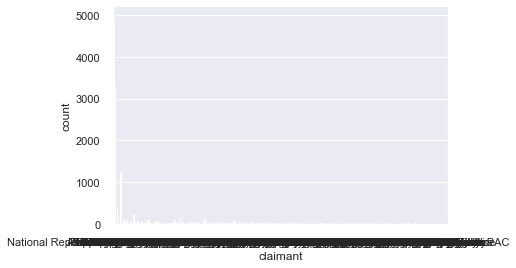

In [21]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="claimant", data=features)

In [43]:
article_df_enriched = article_df_enriched['article_df_enriched']
article_df_enriched.head()

,id,text,word_count,token_count,sentence_count,brevity_score,filtered_text,nltk_pos_neg_neu_compound,nltk_pos,nltk_neg,nltk_neu,nltk_comp
0,106081,Trump Supporter “Kicked Pregnant Muslim Woman ...,225,330,14,0.681818,"[Trump, Supporter, “, Kicked, Pregnant, Muslim...","[0.027, 0.254, 0.719, -0.9973]",0.027,0.254,0.719,-0.9973
1,129341,UW Facts and Figures – University of Wisconsin...,50,69,2,0.724638,"[UW, Facts, Figures, –, University, Wisconsin–...","[0.0, 0.0, 1.0, 0.0]",0.000,0.000,1.000,0.0000
2,100963,Gun Control Advocates Target Peaceful Switzerl...,1055,1549,53,0.681085,"[Gun, Control, Advocates, Target, Peaceful, Sw...","[0.092, 0.101, 0.807, -0.8059]",0.092,0.101,0.807,-0.8059
3,12200,U.S. and Republic of Korea Conclude New Specia...,202,284,8,0.711268,"[U.S., Republic, Korea, Conclude, New, Special...","[0.221, 0.01, 0.769, 0.9952]",0.221,0.010,0.769,0.9952
4,128496,Kremlin's persistent claim of “expected chemic...,437,679,18,0.643594,"[Kremlin, 's, persistent, claim, “, expected, ...","[0.043, 0.13, 0.827, -0.9954]",0.043,0.130,0.827,-0.9954


In [48]:
# Aggregating article data to add to features
# Only including positive and neutral sentiment, as neg and comp are highly correlated with pos and neu
j = 0
mean_neg = []
mean_neu = []
mean_brevity = []
var_neg = []
var_neu = []
var_brevity = []
for i, (claim) in enumerate(zip(train_df['train_df'].related_articles)):
    brevity = np.zeros([len(claim[0]), 1])
    neg = np.zeros([len(claim[0]), 1])
    neu = np.zeros([len(claim[0]), 1])
    for k, article_id in enumerate(claim[0]):
        target = article_df_enriched.loc[article_df_enriched['id'] == article_id]
        if target.empty:
            continue
        brevity[k-1, 0] = target['brevity_score'].values
        neg[k-1, 0] = target['nltk_neg'].values  
        neu[k-1, 0] = target['nltk_neu'].values
    mean_neg.append(np.mean(neg))
    mean_neu.append(np.mean(neu))
    mean_brevity.append(np.mean(brevity))
    var_neg.append(np.var(neg))
    var_neu.append(np.var(neu))
    var_brevity.append(np.var(brevity))

features['mean_neg'] = mean_neg
features['mean_neu'] = mean_neu
features['mean_brevity'] = mean_brevity

features['var_neg'] = var_neg
features['var_neu'] = var_neu
features['var_brevity'] = var_brevity

In [22]:
train_df = pickle.load(open('data/20191107_train_df.pkl', 'rb'))

In [23]:
train_df.head()

,claimant,num_related_articles,claim_neg,claim_neu,mean_neg,mean_neu,mean_brevity,var_neg,var_neu,var_brevity
0,anon,4,0.000,0.827,0.061500,0.619250,0.510241,0.002617,0.131856,0.088182
1,anon,3,0.176,0.691,0.007000,0.305000,0.228895,0.000098,0.186050,0.104786
2,anon,3,0.000,1.000,0.010333,0.549000,0.452712,0.000055,0.152401,0.106353
3,anon,3,0.000,1.000,0.093000,0.504333,0.433681,0.004345,0.127280,0.094109
4,other,6,0.344,0.656,0.001500,0.153167,0.116487,0.000011,0.117300,0.067847


In [36]:
features = train_df.iloc[:, 0:2]

In [35]:
features

,claimant,date,num_related_articles
0,anon,2017-07-17,4
1,anon,2018-03-17,3
2,anon,2018-07-18,3
3,anon,2019-02-04,3
4,Hillary Clinton,2016-03-22,6
...,...,...,...
15550,John McCain,2009-02-25,2
15551,anon,2017-06-06,3
15552,Nancy Pelosi,2009-04-23,6
15553,anon,2018-05-14,3


In [11]:
df = pickle.load(open('data/train_df.pkl', 'rb'))['train_df']

In [12]:
labels = df['label']

### Get datetime data

In [33]:
datetime_object = datetime.now()
print(datetime_object)
print('Type :- ',type(datetime_object))

2019-11-10 22:24:38.098914
Type :-  <class 'datetime.datetime'>


In [36]:
features['date'] = pd.to_datetime(features['date'])

In [37]:
# Extract year, month, day, hour, and minute. Assign all these date component to new column.
features['year'] = features['date'].dt.year
features['month'] = features['date'].dt.month
features['day'] = features['date'].dt.day
features.head()

,claimant,date,num_related_articles,year,month,day,hour,minute
0,anon,2017-07-17,4,2017,7,17,0,0
1,anon,2018-03-17,3,2018,3,17,0,0
2,anon,2018-07-18,3,2018,7,18,0,0
3,anon,2019-02-04,3,2019,2,4,0,0
4,Hillary Clinton,2016-03-22,6,2016,3,22,0,0


In [40]:
features.drop('date', axis=1).drop('hour', axis=1).drop('minute', axis=1)

,claimant,num_related_articles,year,month,day
0,anon,4,2017,7,17
1,anon,3,2018,3,17
2,anon,3,2018,7,18
3,anon,3,2019,2,4
4,Hillary Clinton,6,2016,3,22
...,...,...,...,...,...
15550,John McCain,2,2009,2,25
15551,anon,3,2017,6,6
15552,Nancy Pelosi,6,2009,4,23
15553,anon,3,2018,5,14


In [133]:
# Alternative one hot encoding - using pandas.get_dummies
features_ohe_pandas = pd.get_dummies(features, prefix=['claimant'])

In [141]:
features_ohe_pandas

,num_related_articles,claimant_@Sowellnomics,claimant_AFP Fact Check,claimant_Adam Hasner,claimant_Adam Putnam,claimant_African National Congress,claimant_Afrikan Daily,claimant_Ahmednasir Abdullahi,claimant_Al Gore,claimant_Alan Grayson,...,claimant_Will Weatherford,claimant_William Ruto,claimant_Wisconsin Republican Legislative leaders,claimant_WorldNetDaily,claimant_Your News Wire,claimant_YourNewsWire.com,claimant_Yoweri Museveni,claimant_anon,claimant_multiple sources,claimant_other
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15550,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15551,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15552,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15553,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [135]:
pickle_item(data_file_path + "train_df_no_preprocessing.pkl", features_ohe_pandas)

Pickling completed


In [136]:
from sklearn import preprocessing# Get column names first
names = features_ohe_pandas.columns# Create the Scaler object
scaler = preprocessing.StandardScaler()# Fit your data on the scaler object
scaled_features = scaler.fit_transform(features_ohe_pandas)
scaled_features = pd.DataFrame(scaled_features, columns=names)

In [137]:
scaled_features.head()

,num_related_articles,claimant_@Sowellnomics,claimant_AFP Fact Check,claimant_Adam Hasner,claimant_Adam Putnam,claimant_African National Congress,claimant_Afrikan Daily,claimant_Ahmednasir Abdullahi,claimant_Al Gore,claimant_Alan Grayson,...,claimant_Will Weatherford,claimant_William Ruto,claimant_Wisconsin Republican Legislative leaders,claimant_WorldNetDaily,claimant_Your News Wire,claimant_YourNewsWire.com,claimant_Yoweri Museveni,claimant_anon,claimant_multiple sources,claimant_other
0,-0.257627,-0.013889,-0.034971,-0.016038,-0.022684,-0.016038,-0.019644,-0.013889,-0.019644,-0.034971,...,-0.019644,-0.027786,-0.013889,-0.013889,-0.021218,-0.030014,-0.016038,1.461104,-0.067235,-0.517223
1,-0.516837,-0.013889,-0.034971,-0.016038,-0.022684,-0.016038,-0.019644,-0.013889,-0.019644,-0.034971,...,-0.019644,-0.027786,-0.013889,-0.013889,-0.021218,-0.030014,-0.016038,1.461104,-0.067235,-0.517223
2,-0.516837,-0.013889,-0.034971,-0.016038,-0.022684,-0.016038,-0.019644,-0.013889,-0.019644,-0.034971,...,-0.019644,-0.027786,-0.013889,-0.013889,-0.021218,-0.030014,-0.016038,1.461104,-0.067235,-0.517223
3,-0.516837,-0.013889,-0.034971,-0.016038,-0.022684,-0.016038,-0.019644,-0.013889,-0.019644,-0.034971,...,-0.019644,-0.027786,-0.013889,-0.013889,-0.021218,-0.030014,-0.016038,1.461104,-0.067235,-0.517223
4,0.260793,-0.013889,-0.034971,-0.016038,-0.022684,-0.016038,-0.019644,-0.013889,-0.019644,-0.034971,...,-0.019644,-0.027786,-0.013889,-0.013889,-0.021218,-0.030014,-0.016038,-0.684414,-0.067235,-0.517223


In [144]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split # Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features_ohe_pandas, labels, test_size = 0.25, random_state = 42)

In [7]:
export_csv = train_df.to_csv(r'data/20191107_train_df.csv', sep=',', header=True, index=False)

In [145]:
# Pickle train_features, test_features, train_labels, test_labels
pickle_item(data_file_path + "train_features.pkl", train_features)
pickle_item(data_file_path + "test_features.pkl", test_features)
pickle_item(data_file_path + "train_labels.pkl", train_labels)
pickle_item(data_file_path + "test_labels.pkl", test_labels)

Pickling completed
Pickling completed
Pickling completed
Pickling completed


In [140]:
print(train_labels.shape)
print(train_features.shape)
print(test_labels.shape)
print(test_features.shape)

(11666,)
(11666, 502)
(3889,)
(3889, 502)


## Rough Notes

In [ ]:
# Lemmatization
wnl = nltk.WordNetLemmatizer()
lemma = set([wnl.lemmatize(t) for t in tokens])